In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import os
import multiprocessing as mp
from tqdm import tqdm
from scipy.signal import detrend
from scipy.stats import linregress

from matplotlib import rcParams
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
from scipy.stats import linregress
import warnings

rcParams['font.family'] = 'Inter'
rcParams['font.size'] = 12
rcParams['figure.figsize'] = [5.0, 5.0]
rcParams['figure.dpi'] = 300
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

In [23]:
def get_file_list(product_dir):
    filelist=[]
    for file in sorted(os.listdir(product_dir)):
        filelist.append(os.path.join(product_dir, file))
    return filelist

MODIS_LCSPP_DIR="../../data/MODIS_LCSPP_v3/"
MODIS_LCREF_DIR="../../data/MODIS_LCREF_v3/"
LCSPP_v32_DIR="../../data/LCSPP_v3.2/"
LCREF_v32_DIR="../../data/LCREF_v3.2/"
LTDR_LCSPP = "../../data/LTDR_LCSPP/"
LTDR_LCREF = "../../data/LTDR_LCREF/"


LCSPP_v32_LIST=[f for f in get_file_list(LCSPP_v32_DIR) if ".nc" in f]
LCREF_v32_LIST=[f for f in get_file_list(LCREF_v32_DIR) if ".nc" in f]
LTDR_LCSPP_LIST = [f for f in get_file_list(LTDR_LCSPP) if ".nc" in f]
LTDR_LCREF_LIST = [f for f in get_file_list(LTDR_LCREF) if ".nc" in f]


MODIS_LCSPP_FILE_LIST=[f for f in get_file_list(MODIS_LCSPP_DIR) if ".nc" in f]
MODIS_LCREF_FILE_LIST=[f for f in get_file_list(MODIS_LCREF_DIR) if ".nc" in f]

LCSPP_v32_PRE_2001_PERIOD_FILE_LIST=LCSPP_v32_LIST[0:19*24]
LCSPP_v32_POST_2001_PERIOD_FILE_LIST=LCSPP_v32_LIST[19*24:]

LCREF_v32_PRE_2001_PERIOD_FILE_LIST=LCREF_v32_LIST[0:19*24]
LCREF_v32_POST_2001_PERIOD_FILE_LIST=LCREF_v32_LIST[19*24:]


LTDR_LCSPP_PRE_2001_PERIOD_FILE_LIST=LTDR_LCSPP_LIST[0:19*24]
LTDR_LCSPP_POST_2001_PERIOD_FILE_LIST=LTDR_LCSPP_LIST[19*24:]

PICS=pd.read_csv(os.path.join("../../data/", "PICS.csv"))


In [12]:
def extract_lcspp_pics_site(file_list):
    pics_lcspp_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).lcspp_clear_daily
        pics_lcspp_list.append(np.diag(ds.sel(lat=PICS.lat.values, lon=PICS.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_lcspp_list

def extract_nir_pics_site(file_list):
    pics_nir_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).nir
        pics_nir_list.append(np.diag(ds.sel(lat=PICS.lat.values, lon=PICS.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_nir_list

def extract_red_pics_site(file_list):
    pics_red_list=[]
    for file in file_list:
        ds=xr.open_dataset(file).red
        pics_red_list.append(np.diag(ds.sel(lat=PICS.lat.values, lon=PICS.lon.values, method="nearest")[0].values))
        ds.close()
    return pics_red_list

In [26]:
RED_MODIS = extract_red_pics_site(MODIS_LCREF_FILE_LIST)

NIR_MODIS = extract_nir_pics_site(MODIS_LCREF_FILE_LIST)


In [ ]:

RED_AVHRR = extract_red_pics_site(LCREF_v32_LIST)
RED_MODIS = extract_red_pics_site(MODIS_LCREF_FILE_LIST)
RED_LTDR = extract_red_pics_site(LTDR_LCREF_LIST)

NIR_AVHRR = extract_nir_pics_site(LCREF_v32_LIST)
NIR_MODIS = extract_nir_pics_site(MODIS_LCREF_FILE_LIST)
NIR_LTDR = extract_nir_pics_site(LTDR_LCREF_LIST)


RED_AVHRR_MATRIX = np.vstack(RED_AVHRR)
RED_MODIS_MATRIX = np.vstack(RED_MODIS)
RED_LTDR_MATRIX = np.vstack(RED_LTDR)

NIR_AVHRR_MATRIX = np.vstack(NIR_AVHRR)
NIR_MODIS_MATRIX = np.vstack(NIR_MODIS)
NIR_LTDR_MATRIX = np.vstack(NIR_LTDR)


In [28]:
LCSPP_AVHRR= extract_lcspp_pics_site(LCSPP_v32_LIST)
LCSPP_MODIS = extract_lcspp_pics_site(MODIS_LCSPP_FILE_LIST)
LCSPP_LTDR = extract_lcspp_pics_site(LTDR_LCSPP_LIST)


LCSPP_AVHRR_MATRIX = np.vstack(LCSPP_AVHRR)
LCSPP_MODIS_MATRIX = np.vstack(LCSPP_MODIS)
LCSPP_LTDR_MATRIX = np.vstack(LCSPP_MODIS)

In [29]:
fig_dir = "./figs"

In [30]:
RED_AVHRR_MATRIX_mvc=np.zeros((np.int64(RED_AVHRR_MATRIX.shape[0]/2), RED_AVHRR_MATRIX.shape[1]))
for i in range(int(RED_AVHRR_MATRIX.shape[0]/2)):
    RED_AVHRR_MATRIX_mvc[i, :] = np.nanmax(RED_AVHRR_MATRIX[2*i:2*i+2, :], axis=0)
RED_AVHRR_MATRIX_mvc_year=np.zeros((np.int64(RED_AVHRR_MATRIX_mvc.shape[0] /12), RED_AVHRR_MATRIX_mvc.shape[1]))
for i in range(int(RED_AVHRR_MATRIX_mvc_year.shape[0])):
    RED_AVHRR_MATRIX_mvc_year[i, :] = np.nanmean(RED_AVHRR_MATRIX_mvc[12*i:12*i+12, :], axis=0)

RED_AVHRR_MATRIX_mvc_year_normalized=RED_AVHRR_MATRIX_mvc_year/np.mean(RED_AVHRR_MATRIX_mvc_year, axis=0)
RED_AVHRR_MATRIX_mvc_normalized=RED_AVHRR_MATRIX_mvc/np.mean(RED_AVHRR_MATRIX_mvc, axis=0)

In [31]:
RED_MODIS_MATRIX_mvc=np.zeros((np.int64(RED_MODIS_MATRIX.shape[0]/2), RED_MODIS_MATRIX.shape[1]))
for i in range(int(RED_MODIS_MATRIX.shape[0]/2)):
    RED_MODIS_MATRIX_mvc[i, :] = np.nanmax(RED_MODIS_MATRIX[2*i:2*i+2, :], axis=0)
RED_MODIS_MATRIX_mvc_year=np.zeros((np.int64(RED_MODIS_MATRIX_mvc.shape[0] /12), RED_MODIS_MATRIX_mvc.shape[1]))
for i in range(int(RED_MODIS_MATRIX_mvc_year.shape[0])):
    RED_MODIS_MATRIX_mvc_year[i, :] = np.nanmean(RED_MODIS_MATRIX_mvc[12*i:12*i+12, :], axis=0)

RED_MODIS_MATRIX_mvc_year_normalized=RED_MODIS_MATRIX_mvc_year/np.mean(RED_MODIS_MATRIX_mvc_year, axis=0)
RED_MODIS_MATRIX_mvc_normalized=RED_MODIS_MATRIX_mvc/np.mean(RED_MODIS_MATRIX_mvc, axis=0)

In [32]:
NIR_AVHRR_MATRIX_mvc=np.zeros((np.int64(NIR_AVHRR_MATRIX.shape[0]/2), NIR_AVHRR_MATRIX.shape[1]))
for i in range(int(NIR_AVHRR_MATRIX.shape[0]/2)):
    NIR_AVHRR_MATRIX_mvc[i, :] = np.nanmax(NIR_AVHRR_MATRIX[2*i:2*i+2, :], axis=0)
NIR_AVHRR_MATRIX_mvc_year=np.zeros((np.int64(NIR_AVHRR_MATRIX_mvc.shape[0] /12), NIR_AVHRR_MATRIX_mvc.shape[1]))
for i in range(int(NIR_AVHRR_MATRIX_mvc_year.shape[0])):
    NIR_AVHRR_MATRIX_mvc_year[i, :] = np.nanmean(NIR_AVHRR_MATRIX_mvc[12*i:12*i+12, :], axis=0)

NIR_AVHRR_MATRIX_mvc_year_normalized=NIR_AVHRR_MATRIX_mvc_year/np.mean(NIR_AVHRR_MATRIX_mvc_year, axis=0)
NIR_AVHRR_MATRIX_mvc_normalized=NIR_AVHRR_MATRIX_mvc/np.mean(NIR_AVHRR_MATRIX_mvc, axis=0)

In [33]:
NIR_MODIS_MATRIX_mvc=np.zeros((np.int64(NIR_MODIS_MATRIX.shape[0]/2), NIR_MODIS_MATRIX.shape[1]))
for i in range(int(NIR_MODIS_MATRIX.shape[0]/2)):
    NIR_MODIS_MATRIX_mvc[i, :] = np.nanmax(NIR_MODIS_MATRIX[2*i:2*i+2, :], axis=0)
NIR_MODIS_MATRIX_mvc_year=np.zeros((np.int64(NIR_MODIS_MATRIX_mvc.shape[0] /12), NIR_MODIS_MATRIX_mvc.shape[1]))
for i in range(int(NIR_MODIS_MATRIX_mvc_year.shape[0])):
    NIR_MODIS_MATRIX_mvc_year[i, :] = np.nanmean(NIR_MODIS_MATRIX_mvc[12*i:12*i+12, :], axis=0)

NIR_MODIS_MATRIX_mvc_year_normalized=NIR_MODIS_MATRIX_mvc_year/np.mean(NIR_MODIS_MATRIX_mvc_year, axis=0)
NIR_MODIS_MATRIX_mvc_normalized=NIR_MODIS_MATRIX_mvc/np.mean(NIR_MODIS_MATRIX_mvc, axis=0)

In [34]:
LCSPP_AVHRR_MATRIX_mvc=np.zeros((np.int64(LCSPP_AVHRR_MATRIX.shape[0]/2), LCSPP_AVHRR_MATRIX.shape[1]))
for i in range(int(LCSPP_AVHRR_MATRIX.shape[0]/2)):
    LCSPP_AVHRR_MATRIX_mvc[i, :] = np.nanmax(LCSPP_AVHRR_MATRIX[2*i:2*i+2, :], axis=0)
LCSPP_AVHRR_MATRIX_mvc_year=np.zeros((np.int64(LCSPP_AVHRR_MATRIX_mvc.shape[0] /12), LCSPP_AVHRR_MATRIX_mvc.shape[1]))
for i in range(int(LCSPP_AVHRR_MATRIX_mvc_year.shape[0])):
    LCSPP_AVHRR_MATRIX_mvc_year[i, :] = np.nanmean(LCSPP_AVHRR_MATRIX_mvc[12*i:12*i+12, :], axis=0)

LCSPP_AVHRR_MATRIX_mvc_year_normalized=LCSPP_AVHRR_MATRIX_mvc_year/np.mean(LCSPP_AVHRR_MATRIX_mvc_year, axis=0)
LCSPP_AVHRR_MATRIX_mvc_normalized=LCSPP_AVHRR_MATRIX_mvc/np.mean(LCSPP_AVHRR_MATRIX_mvc, axis=0)

In [35]:
LCSPP_MODIS_MATRIX_mvc=np.zeros((np.int64(LCSPP_MODIS_MATRIX.shape[0]/2), LCSPP_MODIS_MATRIX.shape[1]))
for i in range(int(LCSPP_MODIS_MATRIX.shape[0]/2)):
    LCSPP_MODIS_MATRIX_mvc[i, :] = np.nanmax(LCSPP_MODIS_MATRIX[2*i:2*i+2, :], axis=0)
LCSPP_MODIS_MATRIX_mvc_year=np.zeros((np.int64(LCSPP_MODIS_MATRIX_mvc.shape[0] /12), LCSPP_MODIS_MATRIX_mvc.shape[1]))
for i in range(int(LCSPP_MODIS_MATRIX_mvc_year.shape[0])):
    LCSPP_MODIS_MATRIX_mvc_year[i, :] = np.nanmean(LCSPP_MODIS_MATRIX_mvc[12*i:12*i+12, :], axis=0)

LCSPP_MODIS_MATRIX_mvc_year_normalized=LCSPP_MODIS_MATRIX_mvc_year/np.mean(LCSPP_MODIS_MATRIX_mvc_year, axis=0)
LCSPP_MODIS_MATRIX_mvc_normalized=LCSPP_MODIS_MATRIX_mvc/np.mean(LCSPP_MODIS_MATRIX_mvc, axis=0)

In [36]:
area_weight=xr.open_dataset(os.path.join("../../data/", "CMG_0.05Degree_Area_WGS84.nc")).area.values

NAN_MASK = xr.open_dataset("../../data/processed/LCSPP_LCREF_MASK.nc").LCSPP_LCREF_MASK.values
growing_season_flag = np.invert(np.load("../../data/growing_season_monthly_5C_flag_v32.npy"))

In [37]:
def compute_annual_mean_from_biweekly(file_list, var_name="lcspp_clear_daily"):
    annual_mean_list=[]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', r'All-NaN (slice|axis) encountered')
        warnings.filterwarnings('ignore', r'Mean of empty (slice|axis)')
        for YEAR in tqdm(np.array(file_list).reshape(-1,24)):
            year_list=[]
            for i in range(12):
                first_half_month = xr.open_dataset(YEAR[i*2])[var_name].values[0]
                first_half_month[NAN_MASK]=np.nan
                second_half_month = xr.open_dataset(YEAR[i*2 + 1])[var_name].values[0]  
                second_half_month[NAN_MASK]=np.nan
                mvc = np.nanmax(np.stack([first_half_month, second_half_month]), axis=0)
                mvc[growing_season_flag[i, :, :]] = np.nan
                monthly_mean = np.nansum(mvc * area_weight) / np.nansum(area_weight[np.invert(np.isnan(mvc * area_weight))])
                year_list.append(monthly_mean)
            annual_mean_list.append(np.nanmean(year_list))
        return np.array(annual_mean_list)

In [38]:
LCSPP_avhrr_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(LCSPP_v32_LIST)
LCSPP_modis_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(MODIS_LCSPP_FILE_LIST)
LCSPP_ltdr_weighted_spatial_annual_mean_list=compute_annual_mean_from_biweekly(LTDR_LCSPP_LIST)

100%|███████████████████████████████████████████| 42/42 [08:33<00:00, 12.21s/it]


In [39]:
val_idx = np.load("../../data/pics_val_idx.npy")
NIR_AVHRR_MATRIX_mvc_year=NIR_AVHRR_MATRIX_mvc_year[:, val_idx]
RED_AVHRR_MATRIX_mvc_year=RED_AVHRR_MATRIX_mvc_year[:, val_idx]
NIR_MODIS_MATRIX_mvc_year=NIR_MODIS_MATRIX_mvc_year[:, val_idx]
RED_MODIS_MATRIX_mvc_year=RED_MODIS_MATRIX_mvc_year[:, val_idx]

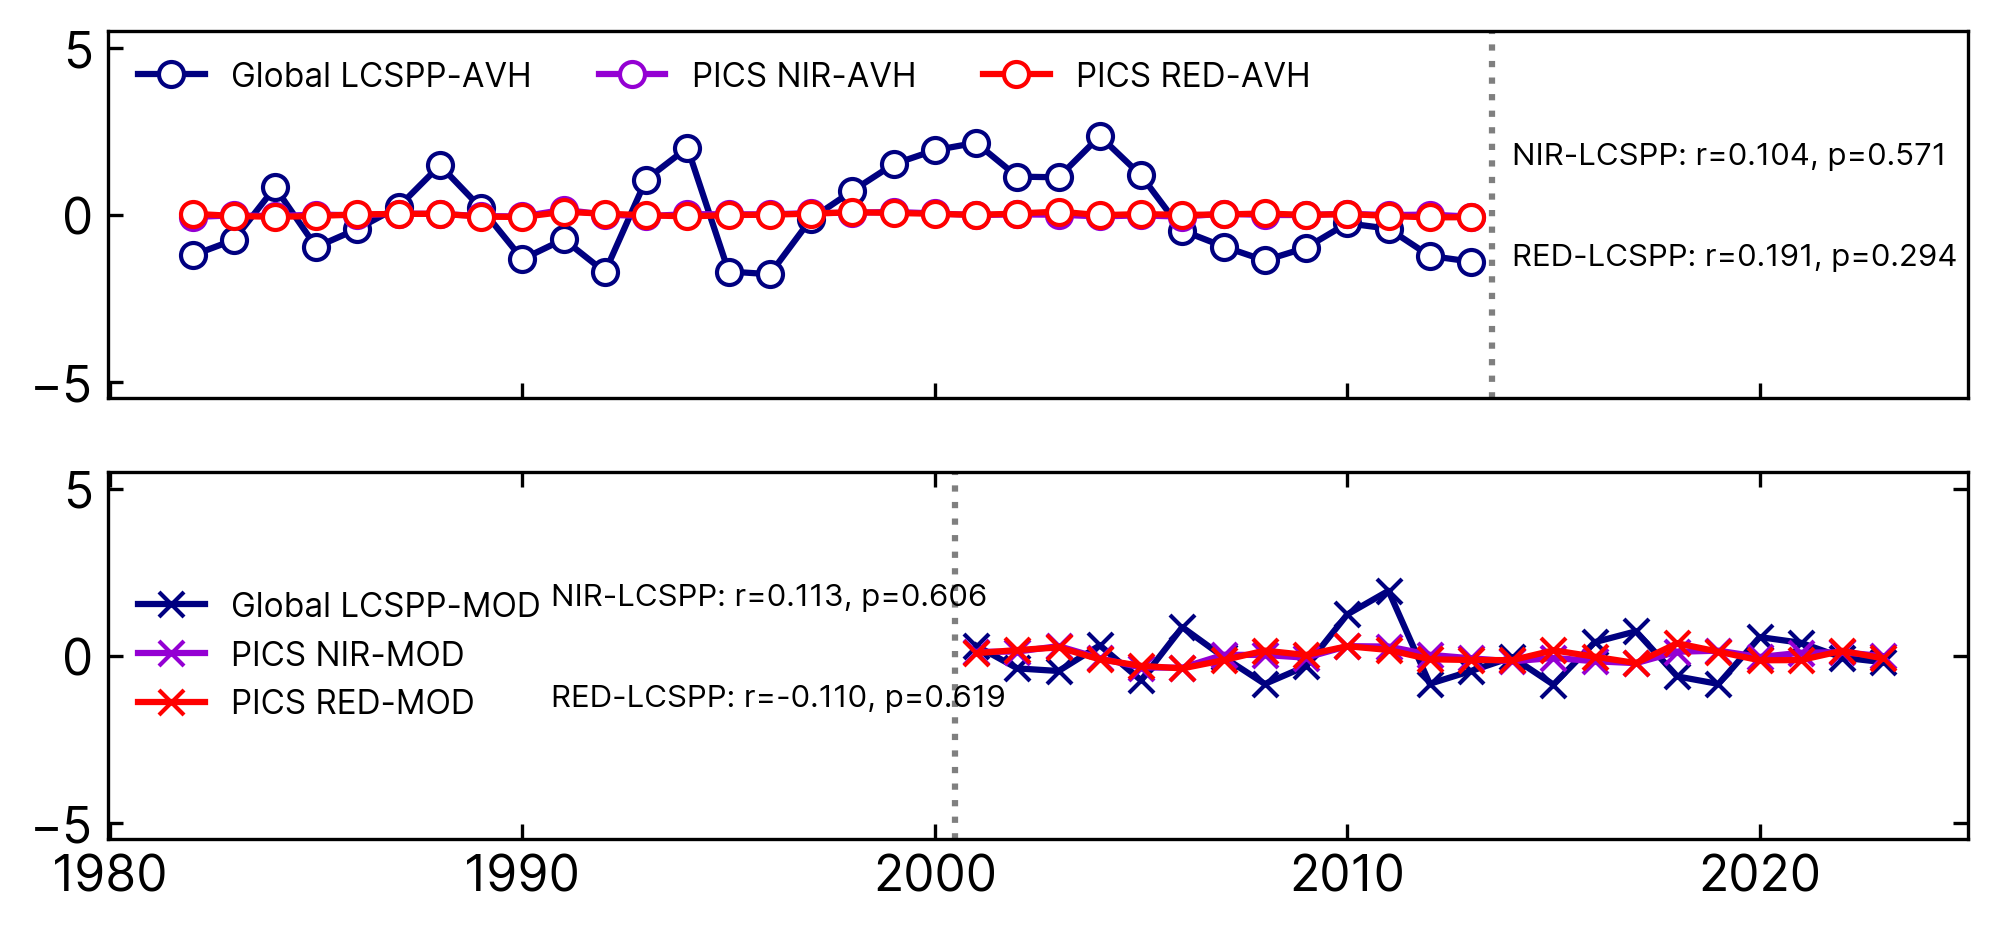

In [40]:
fig, axs = plt.subplots(2, 1, figsize=(8,3.5), sharex=True, dpi=300)
ax=axs.flatten()

NIR_AVHRR_MATRIX_mvc_year_normalized = NIR_AVHRR_MATRIX_mvc_year[:-10, :] / np.mean(NIR_AVHRR_MATRIX_mvc_year[:-10, :], axis=0)
RED_AVHRR_MATRIX_mvc_year_normalized = RED_AVHRR_MATRIX_mvc_year[:-10, :] / np.mean(RED_AVHRR_MATRIX_mvc_year[:-10, :], axis=0)

NIR_METOP_MATRIX_mvc_year_normalized = NIR_AVHRR_MATRIX_mvc_year[-10:, :] / np.mean(NIR_AVHRR_MATRIX_mvc_year[-10:, :], axis=0)
RED_METOP_MATRIX_mvc_year_normalized = RED_AVHRR_MATRIX_mvc_year[-10:, :] / np.mean(RED_AVHRR_MATRIX_mvc_year[-10:, :], axis=0)

NIR_MODIS_MATRIX_mvc_year_normalized = NIR_MODIS_MATRIX_mvc_year / np.mean(NIR_MODIS_MATRIX_mvc_year, axis=0)
RED_MODIS_MATRIX_mvc_year_normalized = RED_MODIS_MATRIX_mvc_year / np.mean(RED_MODIS_MATRIX_mvc_year, axis=0)


NIR_AVHRR_detrend=detrend(np.median(NIR_AVHRR_MATRIX_mvc_year_normalized, axis=1))
RED_AVHRR_detrend=detrend(np.median(RED_AVHRR_MATRIX_mvc_year_normalized, axis=1))
LCSPP_avhrr_detrend=detrend(LCSPP_avhrr_weighted_spatial_annual_mean_list[:-10]/np.mean(LCSPP_avhrr_weighted_spatial_annual_mean_list[:-10]))
LCSPP_metop_detrend=detrend(LCSPP_avhrr_weighted_spatial_annual_mean_list[-9:]/np.mean(LCSPP_avhrr_weighted_spatial_annual_mean_list[-9:]))

NIR_MODIS_detrend=detrend(np.median(NIR_MODIS_MATRIX_mvc_year_normalized, axis=1))
RED_MODIS_detrend=detrend(np.median(RED_MODIS_MATRIX_mvc_year_normalized, axis=1))
LCSPP_modis_detrend=detrend(LCSPP_modis_weighted_spatial_annual_mean_list/np.mean(LCSPP_modis_weighted_spatial_annual_mean_list))

line1, = ax[0].plot(np.arange(1982,2014), LCSPP_avhrr_detrend * 100, "-o", markerfacecolor="white",  c="navy", label="Global LCSPP-AVH")
line2, = ax[0].plot(np.arange(1982,2014), NIR_AVHRR_detrend * 100 , "-o", markerfacecolor="white", c="darkviolet", label= "PICS NIR-AVH")
line3, = ax[0].plot(np.arange(1982,2014), RED_AVHRR_detrend * 100 , "-o", markerfacecolor="white", c="red", label="PICS RED-AVH")

line4, = ax[1].plot(np.arange(2001,2024), LCSPP_modis_detrend * 100, "-x", markerfacecolor="white", c="navy", label="Global LCSPP-MOD")
line5, = ax[1].plot(np.arange(2001,2024), NIR_MODIS_detrend * 100 , "-x", markerfacecolor="white", c="darkviolet", label= "PICS NIR-MOD")
line6, = ax[1].plot(np.arange(2001,2024), RED_MODIS_detrend * 100 , "-x", markerfacecolor="white", c="red", label="PICS RED-MOD")

ax[0].plot([2013.5, 2013.5], [-6, 6], "k:", alpha=0.5)
ax[1].plot([2000.5, 2000.5], [-6, 6], "k:", alpha=0.5)
reg_lcspp_nir_avhrr = linregress(LCSPP_avhrr_detrend, NIR_AVHRR_detrend)
reg_lcspp_red_avhrr = linregress(LCSPP_avhrr_detrend, RED_AVHRR_detrend)

reg_lcspp_nir_modis = linregress(LCSPP_modis_detrend, NIR_MODIS_detrend)
reg_lcspp_red_modis = linregress(LCSPP_modis_detrend, RED_MODIS_detrend)

ax[0].text(2014, 1.5, "NIR-LCSPP: r={:.3f}, p={:.3f}".format(reg_lcspp_nir_avhrr.rvalue, reg_lcspp_nir_avhrr.pvalue), fontsize=7.5)
ax[0].text(2014, -1.5, "RED-LCSPP: r={:.3f}, p={:.3f}".format(reg_lcspp_red_avhrr.rvalue, reg_lcspp_red_avhrr.pvalue), fontsize=7.5)

ax[1].text(1990.7, 1.5, "NIR-LCSPP: r={:.3f}, p={:.3f}".format(reg_lcspp_nir_modis.rvalue, reg_lcspp_nir_modis.pvalue), fontsize=7.5)
ax[1].text(1990.7, -1.5, "RED-LCSPP: r={:.3f}, p={:.3f}".format(reg_lcspp_red_modis.rvalue, reg_lcspp_red_modis.pvalue), fontsize=7.5)

ax[0].set_ylim(-5.5, 5.5)

ax[1].set_ylim(-5.5, 5.5)
#plt.text("Detrended Normalized Anomalies (%)")
plt.tick_params(right=True, top=True)

ax[0].legend(handles=[line1, line2, line3], ncol=3, loc="upper left", frameon=False, fontsize=8)

ax[1].legend(handles=[line4, line5, line6], ncol=1, loc="center left", frameon=False, fontsize=8)

#plt.savefig(os.path.join(fig_dir, "PICSNIR_GLOBALLCSPP_Detrended_Normalzied_Bias_nan_mean.pdf"))